# Image Segmentation with U-Net

Welcome to the final assignment of Week 3! You'll be building your own U-Net, a type of CNN designed for quick, precise image segmentation, and using it to predict a label for every single pixel in an image - in this case, an image from a self-driving car dataset. 

This type of image classification is called semantic image segmentation. It's similar to object detection in that both ask the question: "What objects are in this image and where in the image are those objects located?," but where object detection labels objects with bounding boxes that may include pixels that aren't part of the object, semantic image segmentation allows you to predict a precise mask for each object in the image by labeling each pixel in the image with its corresponding class. The word “semantic” here refers to what's being shown, so for example the “Car” class is indicated below by the dark blue mask, and "Person" is indicated with a red mask:

<img src="images/carseg.png" style="width:500px;height:250;">
<caption><center> <u><b>Figure 1</u></b>: Example of a segmented image <br> </center></caption>

As you might imagine, region-specific labeling is a pretty crucial consideration for self-driving cars, which require a pixel-perfect understanding of their environment so they can change lanes and avoid other cars, or any number of traffic obstacles that can put peoples' lives in danger. 

By the time you finish this notebook, you'll be able to: 

* Build your own U-Net
* Explain the difference between a regular CNN and a U-net
* Implement semantic image segmentation on the CARLA self-driving car dataset
* Apply sparse categorical crossentropy for pixelwise prediction

Onward, to this grand and glorious quest!

## Important Note on Submission to the AutoGrader

Before submitting your assignment to the AutoGrader, please make sure you are not doing the following:

1. You have not added any _extra_ `print` statement(s) in the assignment.
2. You have not added any _extra_ code cell(s) in the assignment.
3. You have not changed any of the function parameters.
4. You are not using any global variables inside your graded exercises. Unless specifically instructed to do so, please refrain from it and use the local variables instead.
5. You are not changing the assignment code where it is not required, like creating _extra_ variables.

If you do any of the following, you will get something like, `Grader Error: Grader feedback not found` (or similarly unexpected) error upon submitting your assignment. Before asking for help/debugging the errors in your assignment, check for these first. If this is the case, and you don't remember the changes you have made, you can get a fresh copy of the assignment by following these [instructions](https://www.coursera.org/learn/convolutional-neural-networks/supplement/DS4yP/h-ow-to-refresh-your-workspace).

## Table of Content

- [1 - Packages](#1)
- [2 - Load and Split the Data](#2)
    - [2.1 - Split Your Dataset into Unmasked and Masked Images](#2-1)
    - [2.2 - Preprocess Your Data](#2-2)
- [3 - U-Net](#3)
    - [3.1 - Model Details](#3-1)
    - [3.2 - Encoder (Downsampling Block)](#3-2)
        - [Exercise 1 - conv_block](#ex-1)
    - [3.3 - Decoder (Upsampling Block)](#3-3)
        - [Exercise 2 - upsampling_block](#ex-2)
    - [3.4 - Build the Model](#3-4)
        - [Exercise 3 - unet_model](#ex-3)
    - [3.5 - Set Model Dimensions](#3-5)
    - [3.6 - Loss Function](#3-6)
    - [3.7 - Dataset Handling](#3-7)
- [4 - Train the Model](#4)
    - [4.1 - Create Predicted Masks](#4-1)
    - [4.2 - Plot Model Accuracy](#4-2)
    - [4.3 - Show Predictions](#4-3)

<a name='1'></a>
## 1 - Packages

Run the cell below to import all the libraries you'll need:

In [30]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## 2 - Load and Split the Data

In [31]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

imgH = 96
imgW = 128


path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')

# image_list_orig = os.listdir(image_path)
image_list_orig = [f for f in os.listdir(image_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

image_list = [image_path+i for i in image_list_orig]
mask_list = [mask_path+i for i in image_list_orig]

### Check out the some of the unmasked and masked images from the dataset:

After you are done exploring, revert back to `N=2`. Otherwise the autograder will throw a `list index out of range` error.

/var/folders/rs/fy3f7n2s3px07zx9b7s4bym80000gn/T/ipykernel_1468/4260092642.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/var/folders/rs/fy3f7n2s3px07zx9b7s4bym80000gn/T/ipykernel_1468/4260092642.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


Text(0.5, 1.0, 'Segmentation')

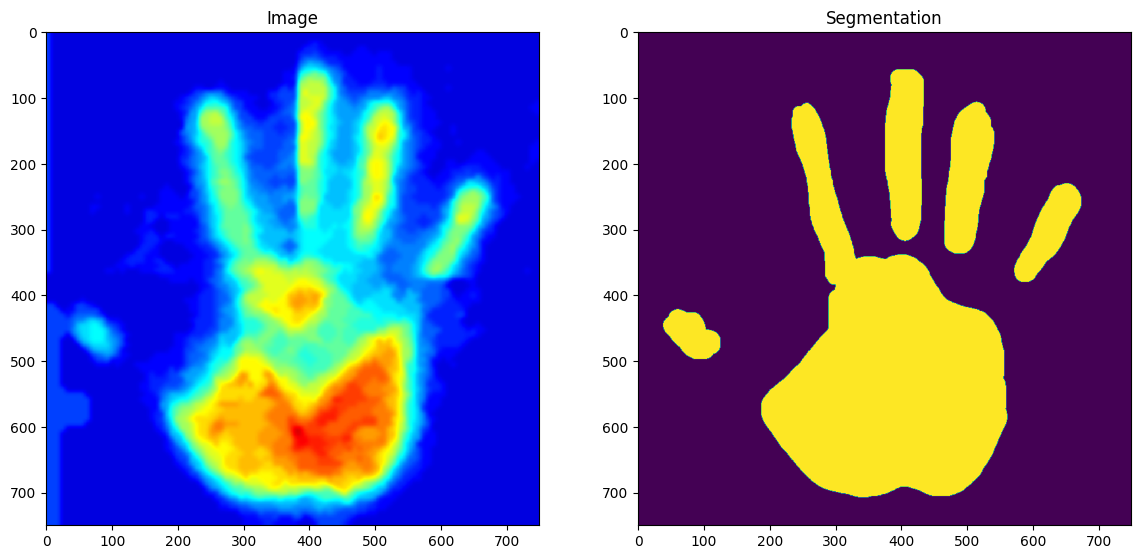

In [32]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)  # 直接使用mask进行绘制，不需要提取通道
arr[1].set_title('Segmentation')

<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [33]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/task-210-annotation-4-by-1-tag-main-palm-0.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/task-210-annotation-4-by-1-tag-main-palm-0.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/task-211-annotation-5-by-1-tag-main-palm-0.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/task-211-annotation-5-by-1-tag-main-palm-0.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/task-212-annotation-84-by-1-tag-main-palm-0.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/task-212-annotation-84-by-1-tag-main-palm-0.png'>)


In [34]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/task-231-annotation-25-by-1-tag-main-palm-0.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/task-231-annotation-25-by-1-tag-main-palm-0.png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

Normally, you normalize your image values by dividing them by `255`. This sets them between `0` and `1`. However, using `tf.image.convert_image_dtype` with `tf.float32` sets them between `0` and `1` for you, so there's no need to further divide them by `255`.

In [35]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (imgH, imgW), method='nearest')
    input_mask = tf.image.resize(mask, (imgH, imgW), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## 3 - U-Net 


<a name='3-1'></a>
### 3.1 - Model Details

<img src="images/unet.png" style="width:700px;height:400;">
<caption><center> <u><b> Figure 2 </u></b>: U-Net Architecture<br> </center></caption>


<a name='3-2'></a>
### 3.2 - Encoder (Downsampling Block) 

<img src="images/encoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 3</u></b>: The U-Net Encoder up close <br> </center></caption>

The encoder is a stack of various conv_blocks:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. 

The function will  return two tensors: 
- `next_layer`: That will go into the next block. 
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer(Conv2D or Dropout, depending on the case). Else, both results will be identical.  


In [36]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    ### START CODE HERE
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation="relu",
                  padding="same",
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation="relu",
                  padding="same",
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2,2))(conv)
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

<a name='3-3'></a>
### 3.3 - Decoder (Upsampling Block)

The decoder, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block.

<img src="images/decoder.png" style="width:500px;height:500;">
<caption><center> <u><b>Figure 4</u></b>: The U-Net Decoder up close <br> </center></caption>

There are two new components in the decoder: `up` and `merge`. These are the transpose convolution and the skip connections. In addition, there are two more convolutional layers set to the same parameters as in the encoder. 

Here you'll encounter the `Conv2DTranspose` layer, which performs the inverse of the `Conv2D` layer. You can read more about it [here.](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)



In [37]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation="relu",
                 padding="same",
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation="relu",
                 padding="same",
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    
    return conv

<a name='3-4'></a>
### 3.4 - Build the Model


In [38]:
# UNQ_C3
# GRADED FUNCTION: unet_model
def unet_model(input_size=(imgH, imgW, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],   n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],   n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],   n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding="same")(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [39]:
img_height = imgH
img_width = imgW
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [40]:
unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 96, 128, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 96, 128, 32)  896         ['input_3[0][0]']                
                                                                                                  
 conv2d_41 (Conv2D)             (None, 96, 128, 32)  9248        ['conv2d_40[0][0]']              
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 48, 64, 32)  0           ['conv2d_41[0][0]']        

<a name='3-6'></a>
### 3.6 - Loss Function

In semantic segmentation, you need as many masks as you have object classes. In the dataset you're using, each pixel in every mask has been assigned a single integer probability that it belongs to a certain class, from 0 to num_classes-1. The correct class is the layer with the higher probability. 

This is different from categorical crossentropy, where the labels should be one-hot encoded (just 0s and 1s). Here, you'll use sparse categorical crossentropy as your loss function, to perform pixel-wise multiclass prediction. Sparse categorical crossentropy is more efficient than other loss functions when you're dealing with lots of classes.

In [41]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [42]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(750, 750, 1)


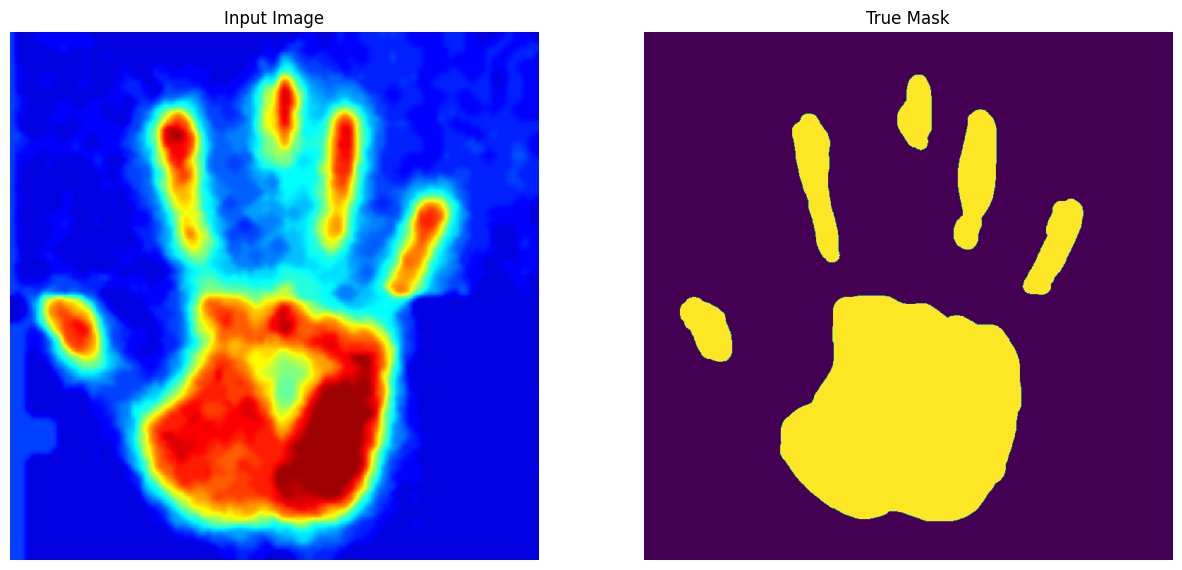

In [43]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


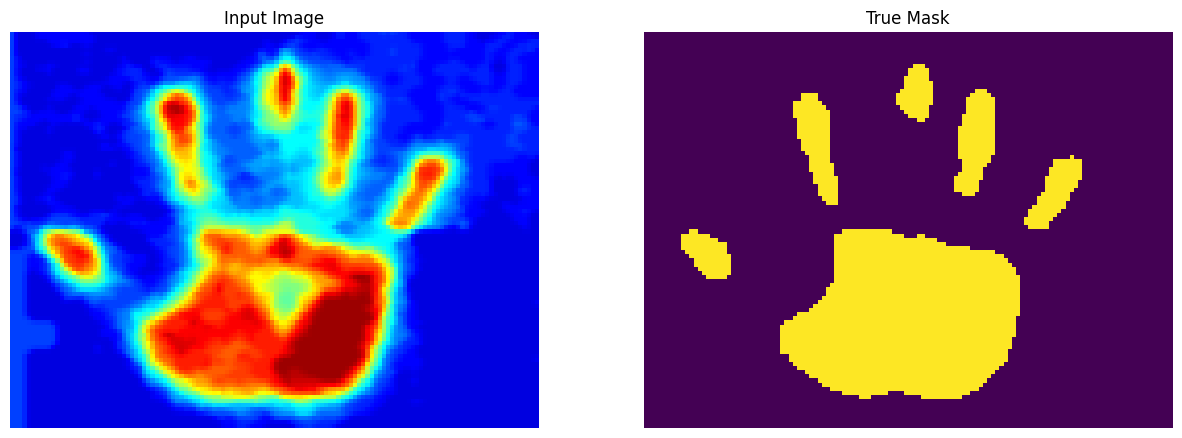

In [44]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [56]:
EPOCHS = 10
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/10


2/2 [==============================] - 4s 1s/step - loss: 0.3545 - accuracy: 0.8641
Epoch 2/10
2/2 [==============================] - 3s 2s/step - loss: 0.2614 - accuracy: 0.8981
Epoch 3/10
2/2 [==============================] - 3s 1s/step - loss: 0.2041 - accuracy: 0.9268
Epoch 4/10
2/2 [==============================] - 3s 1s/step - loss: 0.1751 - accuracy: 0.9335
Epoch 5/10
2/2 [==============================] - 3s 2s/step - loss: 0.1655 - accuracy: 0.9370
Epoch 6/10
2/2 [==============================] - 3s 2s/step - loss: 0.1613 - accuracy: 0.9389
Epoch 7/10
2/2 [==============================] - 3s 2s/step - loss: 0.1807 - accuracy: 0.9309
Epoch 8/10
2/2 [==============================] - 4s 2s/step - loss: 0.1739 - accuracy: 0.9386
Epoch 9/10
2/2 [==============================] - 3s 2s/step - loss: 0.1710 - accuracy: 0.9320
Epoch 10/10
2/2 [==============================] - 3s 2s/step - loss: 0.1554 - accuracy: 0.9381


<a name='4'></a>
### 4.0 - save models and weights

In [57]:
# import os

# weights_path = "./weights"
# models_path = "./models"
# if not os.path.exists(weights_path):
#     os.mkdir(weights_path)
# if not os.path.exists(models_path):
#     os.mkdir(models_path)

# weights_file_path = os.path.join(weights_path, 'my_model_weights.h5')
# models_file_path = os.path.join(models_path, 'my_complete_model.h5')

# unet.save_weights(weights_file_path)

# unet.save(models_file_path)


<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [58]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

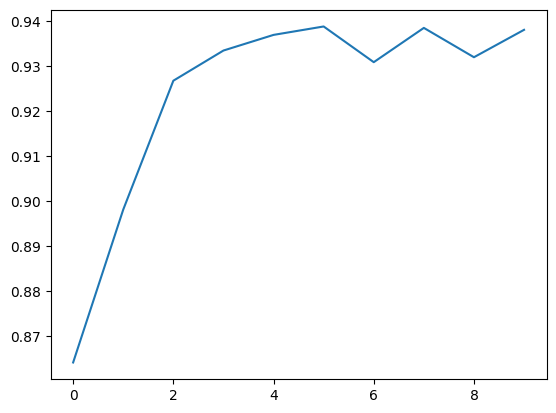

In [59]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [60]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

# 下面介绍unet.predict()函数为什么是这样的输入：
# U-Net模型（以及大多数深度学习模型）期望的输入数据格式是四维张量：`(batch_size, height, width, channels)`。

# 这里的每个维度意味着：

# 1. `batch_size`：一次预测中的样本数量。深度学习模型通常是为了批处理而设计的，这样可以更有效地利用GPU进行并行计算。
# 2. `height`：图片的高度。
# 3. `width`：图片的宽度。
# 4. `channels`：每个像素的通道数。例如，对于彩色图像，通常有3个通道（红、绿、蓝）。

# 在您提供的例子中：`unet.predict(sample_image[tf.newaxis, ...])`

# - `sample_image` 可能是一个形状为 `(height, width, channels)` 的三维张量，表示一个单独的图像。
# - `tf.newaxis` 在TensorFlow中用于增加一个新的维度。这样，您可以将三维的 `sample_image` 转换为四维张量。
# - `...` 是Python的ellipsis对象，表示选择所有剩余的维度。所以，在这里，它选择了 `sample_image` 的所有维度。
  
# 综合上述，`sample_image[tf.newaxis, ...]` 将 `sample_image` 的形状从 `(height, width, channels)` 改变为 `(1, height, width, channels)`。这样，它就可以作为模型的输入，而模型则期望一个四维张量。

# 简而言之，这个操作是为了满足模型输入的四维张量格式要求，其中 `batch_size` 设置为1，因为我们只预测一个样本。

1/1 [==============================] - 1s 630ms/step


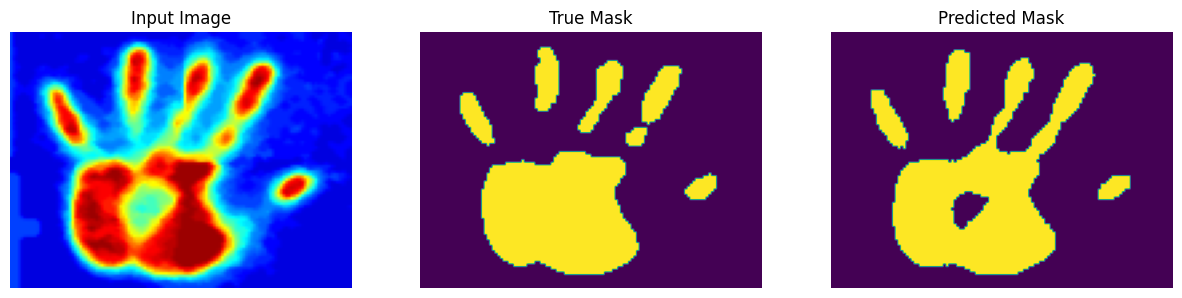

1/1 [==============================] - 0s 456ms/step


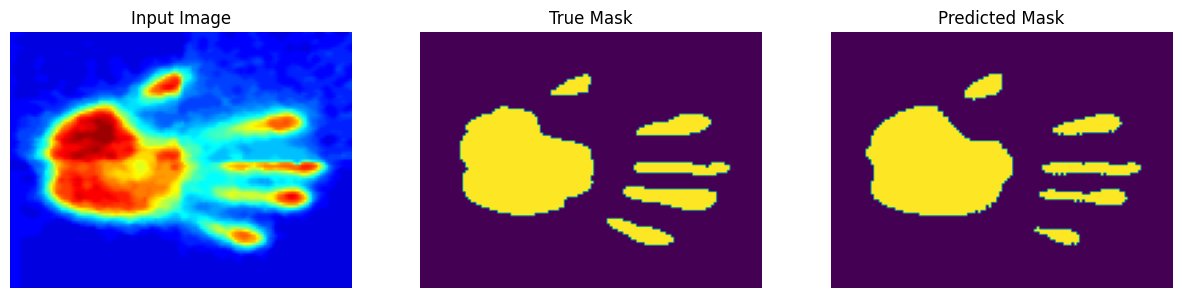

In [61]:
show_predictions(train_dataset, 6)

With 40 epochs you get amazing results!


### Conclusion 

You've come to the end of this assignment. Awesome work creating a state-of-the art model for semantic image segmentation! This is a very important task for self-driving cars to get right. Elon Musk will surely be knocking down your door at any moment. ;) 

<font color='blue'>
    
**What you should remember**: 

* Semantic image segmentation predicts a label for every single pixel in an image
* U-Net uses an equal number of convolutional blocks and transposed convolutions for downsampling and upsampling
* Skip connections are used to prevent border pixel information loss and overfitting in U-Net

## try your own

In [62]:
import tensorflow as tf

models_file_path = "./models/my_complete_model.h5"
unet = tf.keras.models.load_model(models_file_path)

def preprocess_single_image(image_path, mask_path=None):
    # 1. Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 2. If a mask path is provided, process the mask
    if mask_path:
        mask = tf.io.read_file(mask_path)
        mask = tf.image.decode_png(mask, channels=3)
        mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    else:
        mask = None

    # 3. Resize the image (and mask if present)
    input_image = tf.image.resize(img, (imgH, imgW), method='nearest')
    if mask:
        input_mask = tf.image.resize(mask, (imgH, imgW), method='nearest')
    else:
        input_mask = None

    return input_image, input_mask


1/1 [==============================] - 0s 115ms/step


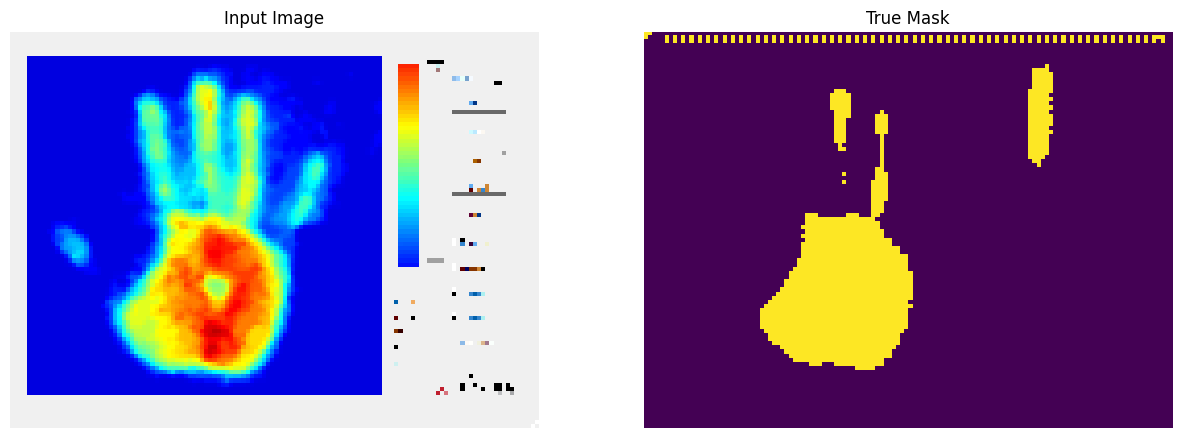

In [63]:
# Example usage:
image_path = "./2022-12-14T13_39_58.514_palm.png"
mask_path = None
# Assuming you've already preprocessed your single image and mask:
input_image, input_mask = preprocess_single_image(image_path, mask_path)

# If the model expects a batched input, add a batch dimension
input_image = input_image[tf.newaxis, ...]
if input_mask:
    input_mask = input_mask[tf.newaxis, ...]

# Predict
predicted_mask = unet.predict(input_image)

# Display
display([input_image[0], create_mask(predicted_mask)])


## 更改图片大小

可以使用resize或者seam carver 算法

In [64]:
# import sys
# sys.executable

'/Users/mixin/miniforge3/envs/u-net/bin/python'

## 制作mask图片的辅助工具


为U-Net样本生成遮罩（mask）确实是一个重要步骤。这通常涉及到标注或分割过程，即将图像中的每一个像素分配给一个类别。有多种工具可以帮助你进行此类任务。

以下是一些流行的图像分割标注工具：

1. **Labelme**: 你已经提到了这个。Labelme不仅仅是为YOLO设计的;它也支持图像分割。

   [Labelme GitHub Repo](https://github.com/wkentaro/labelme)

2. **VGG Image Annotator (VIA)**: 由VGG（Visual Geometry Group）开发，这是一个非常简单的，易于使用的，基于Web的工具，支持多种类型的图像标注任务，包括图像分割。

   [VGG Image Annotator (VIA)](https://www.robots.ox.ac.uk/~vgg/software/via/)

3. **Mask R-CNN**: 这是一个工具，用于标记用于Mask R-CNN模型的对象实例，但也可以用于U-Net。

   [Mask R-CNN GitHub Repo](https://github.com/matterport/Mask_RCNN)

4. **PixelAnnotationTool**: 这是一个用于图像分割的工具，允许你进行像素级的标注。

   [PixelAnnotationTool GitHub Repo](https://github.com/abreheret/PixelAnnotationTool)

5. **ITK-SNAP**: 这是一个流行的医学图像分割工具，但也可以用于其他图像分割任务。

   [ITK-SNAP Website](http://www.itksnap.org/pmwiki/pmwiki.php)

选择哪个工具通常取决于你的具体需求和个人喜好。建议你尝试几个工具，看看哪一个最适合你的工作流程。